# Memorization vs Generalization

Neuronale Nete sollen sich keine Daten "merken" sondern lenren zu abstrahieren also generalisieren. 

In [1]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
import random, os, json

FORCE_BUILD_MODELS = False

Using TensorFlow backend.


Wir verwenden zu demonstrationszwecken das CIFAR10 Dataset, welches aus 50000 niedrig aufgelösten Bildern besteht, welche 10 verschiedenen Klassen zugeordnet sind. 

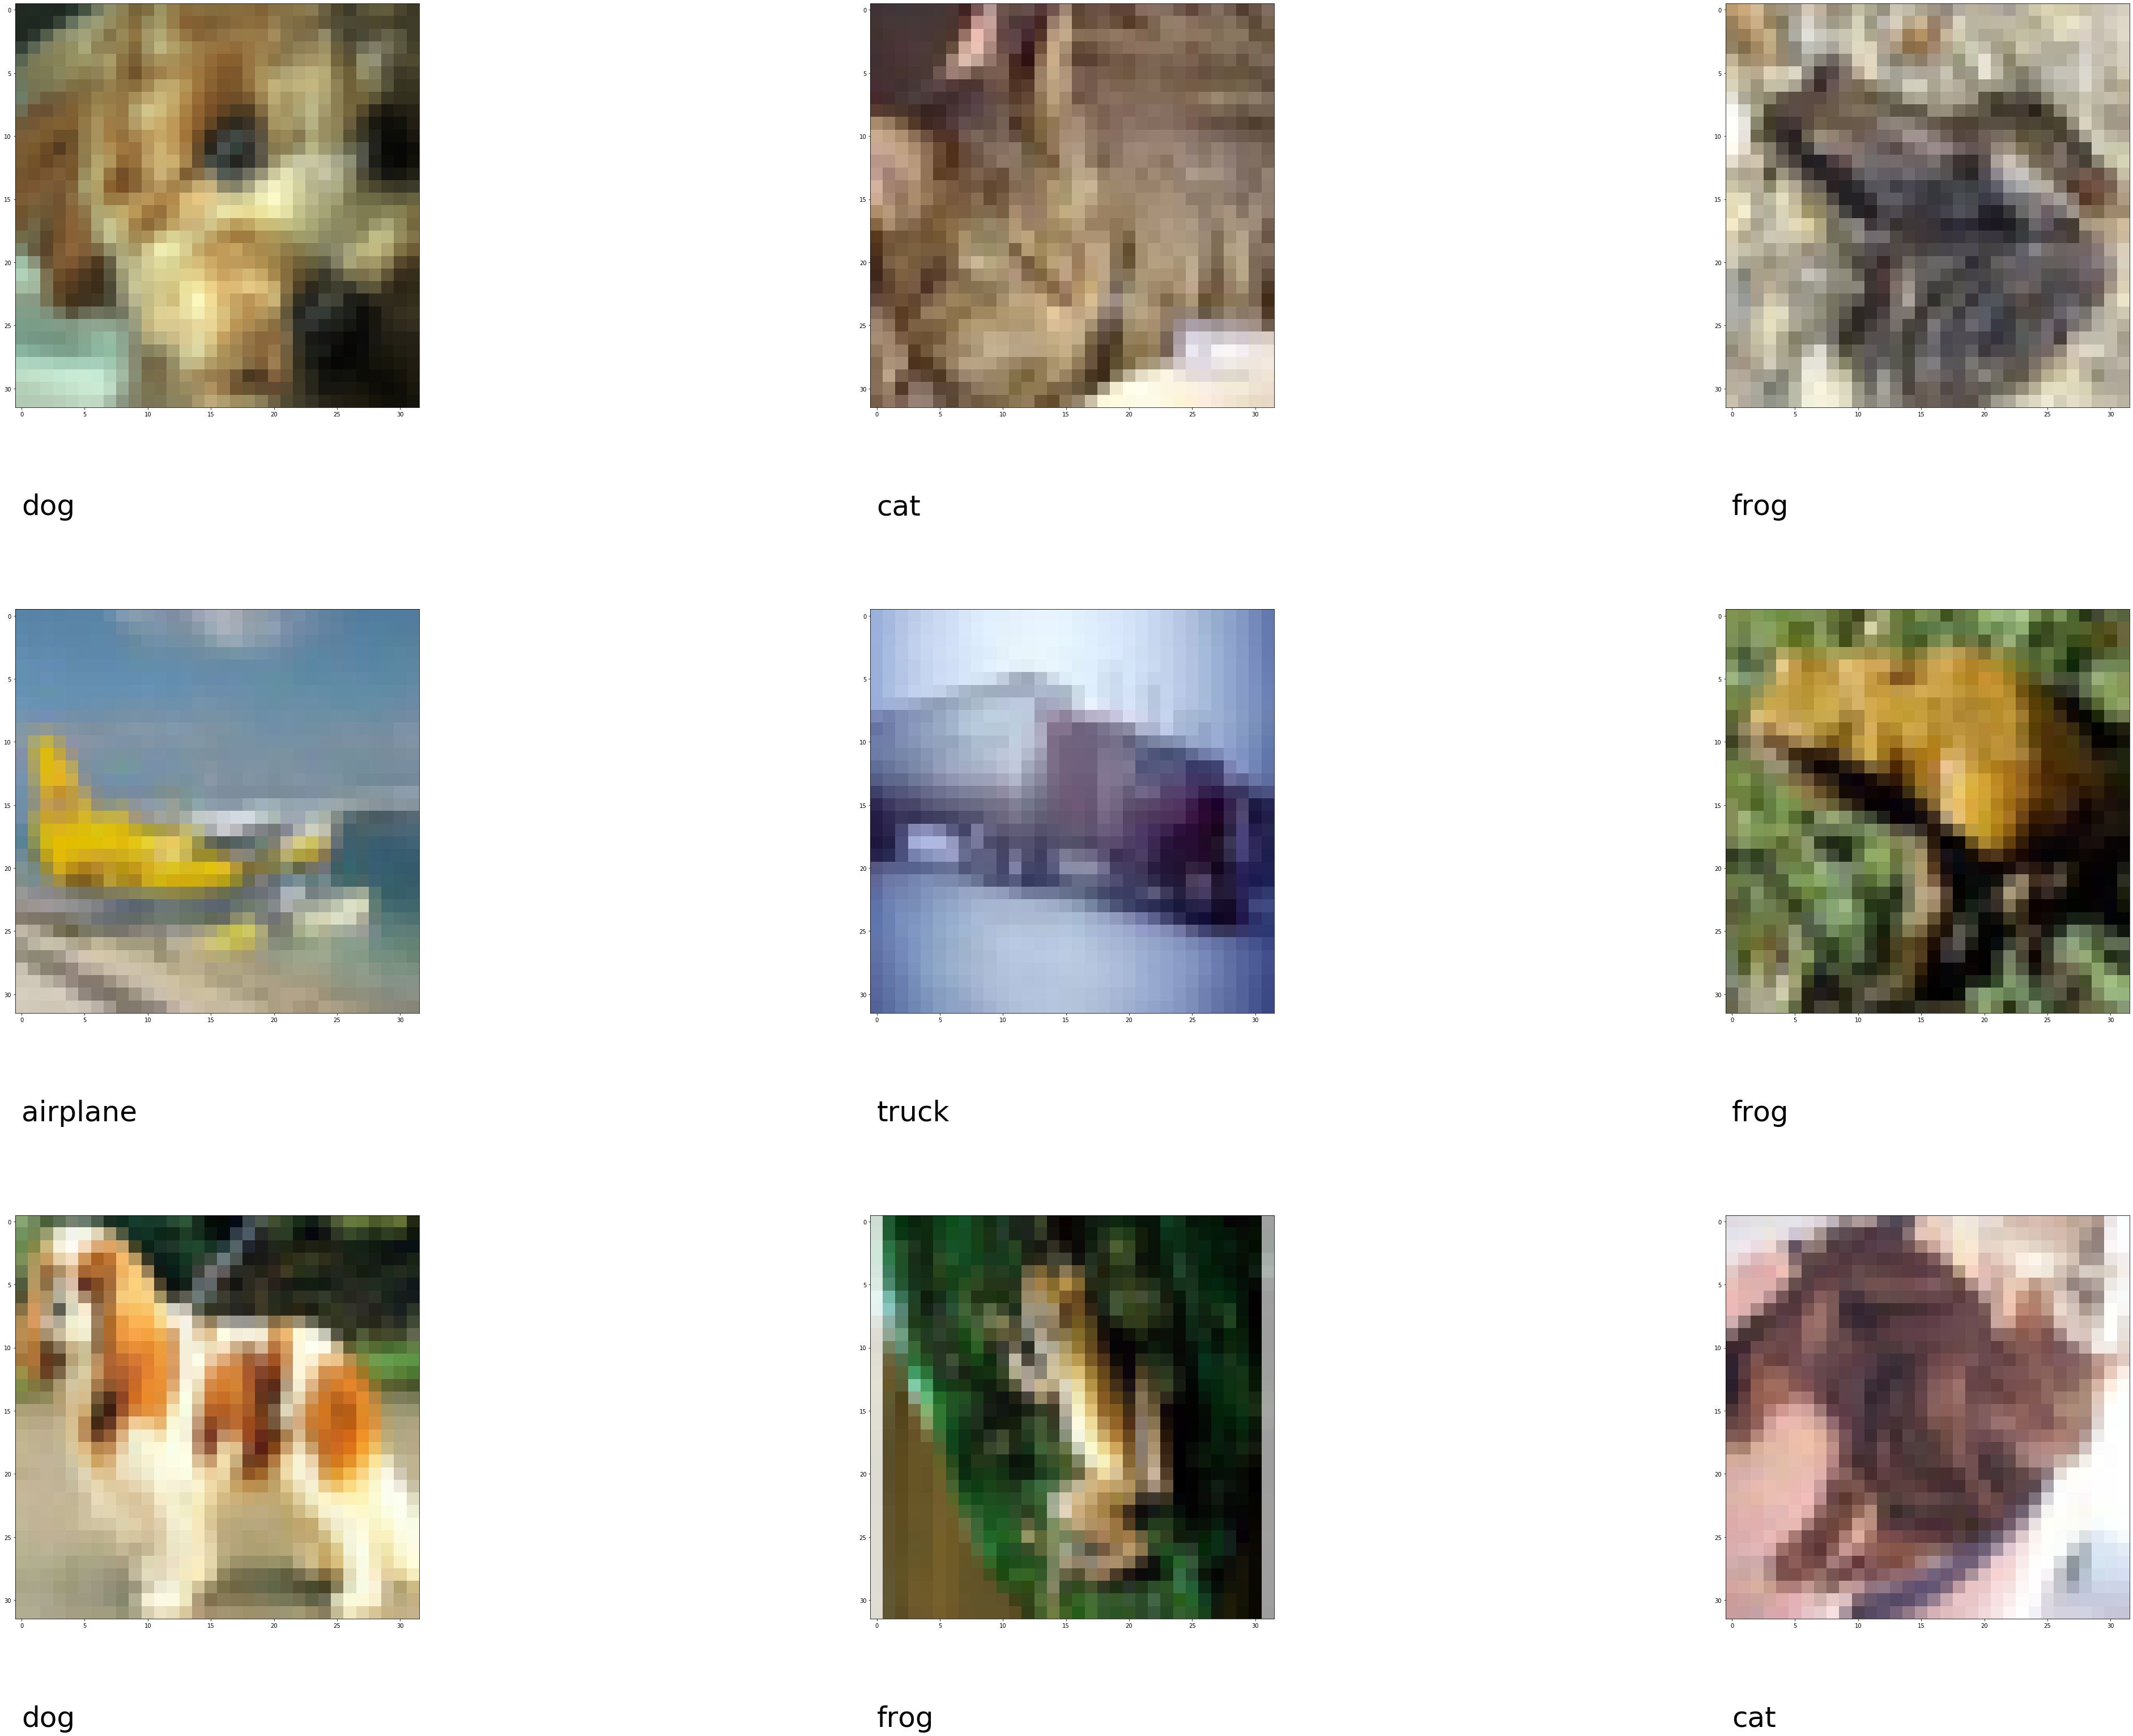

In [2]:
(trainX, trainY), (testX, testY) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(9):
    nr = random.randint(1, len(trainX))
    pyplot.subplot(330 + 1 + i, ymargin=20)
    pyplot.imshow(trainX[nr])
    pyplot.text(0, 40, class_names[trainY[nr][0]], fontsize=50)

#pyplot.tight_layout()
pyplot.subplots_adjust(left=0.1, right=10.0, top=10.0, bottom=0.1, hspace=0.5)
pyplot.show()



In [3]:

#trainX = trainX[:10000,:,:,:]
#testX = testX[:5000,:,:,:]

#trainY = trainY[:10000]
#testY = testY[:5000]

trainY_shuffle = list(trainY)
random.shuffle(trainY_shuffle)


In [4]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainY_shuffle = to_categorical(trainY_shuffle)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

In [5]:
def create_model(conv1, conv2, conv3, dense):
    model = Sequential()
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if conv2 != 0:
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
    if conv3 != 0:
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_summary(history):
    # Plot the loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history['loss'], color='blue', label='train')
    pyplot.plot(history['val_loss'], color='red', label='test')
    # Plot the accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history['acc'], color='blue', label='train')
    pyplot.plot(history['val_acc'], color='red', label='test')

In [6]:


if os.path.isfile('models/small') and not FORCE_BUILD_MODELS:
    model_small = load_model('models/small')
    with open('models/small_history.json') as file:
        history_small = json.load(file)
else:
    model_small = create_model(2, 0, 0, 64)
    history_small = model_small.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY))
    model_small.save('models/small')
    with open('models/small_history.json', 'w') as file:
        json.dump(history_small.history, file)
        history_small = history_small.history



W0707 21:17:13.793031 140298268821312 deprecation_wrapper.py:119] From /home/robin/wvin/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 21:17:13.955441 140298268821312 deprecation_wrapper.py:119] From /home/robin/wvin/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 21:17:14.045345 140298268821312 deprecation_wrapper.py:119] From /home/robin/wvin/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0707 21:17:14.137058 140298268821312 deprecation_wrapper.py:119] From /home/robin/wvin/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0

In [13]:
FORCE_BUILD_MODELS=True

if os.path.isfile('models/random') and not FORCE_BUILD_MODELS:
    model_random = load_model('models/random')
    with open('models/random_history.json') as file:
        history_random = json.load(file)
else:
    model_random = create_model(64, 32, 0, 128)
    history_random = model_random.fit(trainX, trainY_shuffle, epochs=150, batch_size=64, validation_data=(testX, testY))
    model_random.save('models/random')
    with open('models/random_history.json', 'w') as file:
        json.dump(history_random.history, file)
        history_random = history_random.history

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 8s 167us/step - loss: 2.3084 - acc: 0.0974 - val_loss: 2.3047 - val_acc: 0.0795
Epoch 2/150
50000/50000 [==============================] - 8s 158us/step - loss: 2.3028 - acc: 0.1001 - val_loss: 2.3027 - val_acc: 0.0856
Epoch 3/150
50000/50000 [==============================] - 8s 158us/step - loss: 2.3026 - acc: 0.1015 - val_loss: 2.3033 - val_acc: 0.0848
Epoch 4/150
50000/50000 [==============================] - 8s 157us/step - loss: 2.3024 - acc: 0.1025 - val_loss: 2.3017 - val_acc: 0.0938
Epoch 5/150
50000/50000 [==============================] - 8s 158us/step - loss: 2.3023 - acc: 0.1009 - val_loss: 2.3046 - val_acc: 0.1004
Epoch 6/150
50000/50000 [==============================] - 8s 159us/step - loss: 2.3020 - acc: 0.1057 - val_loss: 2.3048 - val_acc: 0.0895
Epoch 7/150
50000/50000 [==============================] - 8s 159us/step - loss: 2.3020 - acc: 0.1045 - val_loss: 2.

50000/50000 [==============================] - 8s 158us/step - loss: 1.7805 - acc: 0.3704 - val_loss: 2.8367 - val_acc: 0.1038
Epoch 60/150
50000/50000 [==============================] - 8s 159us/step - loss: 1.7397 - acc: 0.3851 - val_loss: 2.9418 - val_acc: 0.0992
Epoch 61/150
50000/50000 [==============================] - 8s 158us/step - loss: 1.7014 - acc: 0.4021 - val_loss: 3.0329 - val_acc: 0.1032
Epoch 62/150
50000/50000 [==============================] - 8s 158us/step - loss: 1.6660 - acc: 0.4140 - val_loss: 3.0179 - val_acc: 0.1104
Epoch 63/150
50000/50000 [==============================] - 8s 158us/step - loss: 1.6196 - acc: 0.4329 - val_loss: 3.1116 - val_acc: 0.1054
Epoch 64/150
50000/50000 [==============================] - 8s 159us/step - loss: 1.5730 - acc: 0.4491 - val_loss: 3.3130 - val_acc: 0.0991
Epoch 65/150
50000/50000 [==============================] - 8s 159us/step - loss: 1.5295 - acc: 0.4629 - val_loss: 3.2810 - val_acc: 0.1012
Epoch 66/150
50000/50000 [=======

50000/50000 [==============================] - 8s 158us/step - loss: 0.2693 - acc: 0.9089 - val_loss: 9.3678 - val_acc: 0.1062
Epoch 118/150
50000/50000 [==============================] - 8s 158us/step - loss: 0.3197 - acc: 0.8958 - val_loss: 9.4034 - val_acc: 0.1022
Epoch 119/150
50000/50000 [==============================] - 8s 159us/step - loss: 0.2780 - acc: 0.9089 - val_loss: 9.5689 - val_acc: 0.1022
Epoch 120/150
50000/50000 [==============================] - 8s 158us/step - loss: 0.2477 - acc: 0.9193 - val_loss: 9.5873 - val_acc: 0.1023
Epoch 121/150
50000/50000 [==============================] - 8s 158us/step - loss: 0.2536 - acc: 0.9155 - val_loss: 9.7508 - val_acc: 0.0997
Epoch 122/150
50000/50000 [==============================] - 8s 158us/step - loss: 0.2446 - acc: 0.9198 - val_loss: 9.6863 - val_acc: 0.1032
Epoch 123/150
50000/50000 [==============================] - 8s 159us/step - loss: 0.2519 - acc: 0.9176 - val_loss: 9.9014 - val_acc: 0.0991
Epoch 124/150
50000/50000 [

In [21]:
FORCE_BUILD_MODELS=True

if os.path.isfile('models/normal') and not FORCE_BUILD_MODELS:
    model_normal = load_model('models/normal')
    with open('models/normal_history.json') as file:
        history_normal = json.load(file)
else:
    model_normal = create_model(64, 32, 0, 128)
    history_normal = model_normal.fit(trainX, trainY, epochs=150, batch_size=64, validation_data=(testX, testY))
    model_normal.save('models/normal')
    with open('models/normal_history.json', 'w') as file:
        json.dump(history_normal.history, file)
        history_normal = history_normal.history

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 8s 167us/step - loss: 1.7363 - acc: 0.3743 - val_loss: 1.5762 - val_acc: 0.4328
Epoch 2/150
50000/50000 [==============================] - 8s 158us/step - loss: 1.3821 - acc: 0.5069 - val_loss: 1.3187 - val_acc: 0.5356
Epoch 3/150
50000/50000 [==============================] - 8s 158us/step - loss: 1.2233 - acc: 0.5677 - val_loss: 1.2389 - val_acc: 0.5550
Epoch 4/150
50000/50000 [==============================] - 8s 159us/step - loss: 1.1134 - acc: 0.6084 - val_loss: 1.0757 - val_acc: 0.6188
Epoch 5/150
50000/50000 [==============================] - 8s 159us/step - loss: 1.0187 - acc: 0.6433 - val_loss: 1.0272 - val_acc: 0.6383
Epoch 6/150
50000/50000 [==============================] - 8s 158us/step - loss: 0.9486 - acc: 0.6685 - val_loss: 0.9518 - val_acc: 0.6730
Epoch 7/150
50000/50000 [==============================] - 8s 159us/step - loss: 0.8903 - acc: 0.6883 - val_loss: 0.

50000/50000 [==============================] - 8s 160us/step - loss: 8.3845e-04 - acc: 1.0000 - val_loss: 2.1983 - val_acc: 0.7275
Epoch 60/150
50000/50000 [==============================] - 8s 159us/step - loss: 7.9039e-04 - acc: 1.0000 - val_loss: 2.2079 - val_acc: 0.7287
Epoch 61/150
50000/50000 [==============================] - 8s 159us/step - loss: 7.5067e-04 - acc: 1.0000 - val_loss: 2.2182 - val_acc: 0.7275
Epoch 62/150
50000/50000 [==============================] - 8s 160us/step - loss: 7.0840e-04 - acc: 1.0000 - val_loss: 2.2280 - val_acc: 0.7274
Epoch 63/150
50000/50000 [==============================] - 8s 160us/step - loss: 6.7526e-04 - acc: 1.0000 - val_loss: 2.2379 - val_acc: 0.7282
Epoch 64/150
50000/50000 [==============================] - 8s 159us/step - loss: 6.4488e-04 - acc: 1.0000 - val_loss: 2.2448 - val_acc: 0.7281
Epoch 65/150
50000/50000 [==============================] - 8s 159us/step - loss: 6.1979e-04 - acc: 1.0000 - val_loss: 2.2525 - val_acc: 0.7281
Epoch

Epoch 116/150
50000/50000 [==============================] - 8s 160us/step - loss: 1.8731e-04 - acc: 1.0000 - val_loss: 2.4594 - val_acc: 0.7262
Epoch 117/150
50000/50000 [==============================] - 8s 160us/step - loss: 1.8488e-04 - acc: 1.0000 - val_loss: 2.4625 - val_acc: 0.7265
Epoch 118/150
50000/50000 [==============================] - 8s 159us/step - loss: 1.8263e-04 - acc: 1.0000 - val_loss: 2.4638 - val_acc: 0.7264
Epoch 119/150
50000/50000 [==============================] - 8s 160us/step - loss: 1.7955e-04 - acc: 1.0000 - val_loss: 2.4670 - val_acc: 0.7259
Epoch 120/150
50000/50000 [==============================] - 8s 160us/step - loss: 1.7745e-04 - acc: 1.0000 - val_loss: 2.4689 - val_acc: 0.7267
Epoch 121/150
50000/50000 [==============================] - 8s 159us/step - loss: 1.7493e-04 - acc: 1.0000 - val_loss: 2.4711 - val_acc: 0.7263
Epoch 122/150
50000/50000 [==============================] - 8s 161us/step - loss: 1.7225e-04 - acc: 1.0000 - val_loss: 2.4737 - v

33,576


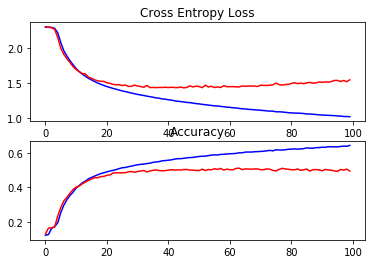

In [22]:
print("{:,}".format(model_small.count_params()))
plot_summary(history_small)

329,994


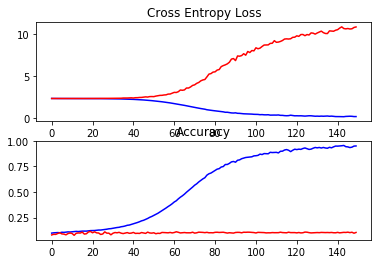

In [18]:
print("{:,}".format(model_random.count_params()))
plot_summary(history_random)

329,994


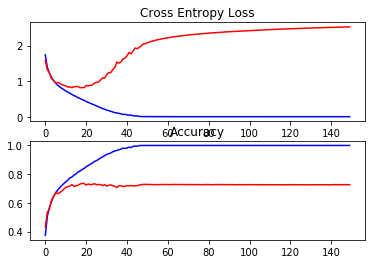

In [23]:
print("{:,}".format(model_normal.count_params()))
plot_summary(history_normal)